In [70]:
import sys
sys.path.append('../../')

import numpy as np
from qiskit import IBMQ, Aer
import matplotlib.pyplot as plt
from main import device_process_measurement_tomography, Quantities, Cross_Quantities,DiamondNorm
from qiskit.compiler import transpile
from qiskit.providers.ibmq.managed import IBMQJobManager
from utils_qiskit import *

In [71]:
IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='csic-1', project='main')
backend = provider.get_backend('ibm_perth')
simulator = Aer.get_backend('aer_simulator')
job_manager = IBMQJobManager()

ibmqfactory.load_account:WARNING:2022-11-08 01:36:23,050: Credentials are already in use. The existing account in the session will be replaced.


In [72]:
parall_qubits =  5*[[[ (0,1), (3,5) ],
                    [ (0,1) ],
                    [ (3,5) ]]] + 5*[[[(1,3),(4,5)],
                    [(1,3)],
                    [(4,5)]]] + 5*[[[(1,2),(5,6)],
                    [(1,2)],
                    [(5,6)]]]
                

In [73]:
job_ids = [
    '7364c64cb08643c8b7a331db8760be76-16638006144369087',
    'a317d2f4d40e4138a90e3d867f81aead-16638008680736837',
    '5561e4224aee40b3b5b4589851fa1ade-16638008773492372',
    '798207b0a1b44a32b79cc4dc3ee95aec-16638008859225643',
    'f548a504154e412c8b8def1e60e8e5a7-16638008944027708',
    'e311fd95fa1343b49c645b96b2303566-16671739751397412',
    '1f04e519ea504f59b0e36b39e3db8238-16671739839581792',
    '139fed624e294286aef063dc0c944bc8-1667173992884656',
    'bcc11d56a06245e69ba804813179c4cf-16671740009086525',
    'd35909ce634c41e09d45e5314f3bd50b-16671740097822661',
    '53616764a6414a2b9ff1167cac45a93b-1667174047268017',
    '14fba4f0c275412f83ad01aff25b556a-16671740564229283',
    '04064d6a0dd24e9ab533192cfd090d99-16671740654108891',
    'e75aabc0b62c46d1a3d4a73dcdf1a5c3-16671740736617362',
    '67b33fcee6d3409c988361c44ae6cff1-16671740825175252'
    ]

# ibm_perth
# [ (0,1), (3,5) ]
# '7364c64cb08643c8b7a331db8760be76-16638006144369087'
# 'a317d2f4d40e4138a90e3d867f81aead-16638008680736837'
# '5561e4224aee40b3b5b4589851fa1ade-16638008773492372'
# '798207b0a1b44a32b79cc4dc3ee95aec-16638008859225643'
# 'f548a504154e412c8b8def1e60e8e5a7-16638008944027708'
# [(1,3),(4,5)]
# e311fd95fa1343b49c645b96b2303566-16671739751397412
# 1f04e519ea504f59b0e36b39e3db8238-16671739839581792
# 139fed624e294286aef063dc0c944bc8-1667173992884656
# bcc11d56a06245e69ba804813179c4cf-16671740009086525
# d35909ce634c41e09d45e5314f3bd50b-16671740097822661
# [(1,2),(5,6)] 
# 53616764a6414a2b9ff1167cac45a93b-1667174047268017
# 14fba4f0c275412f83ad01aff25b556a-16671740564229283
# 04064d6a0dd24e9ab533192cfd090d99-16671740654108891
# e75aabc0b62c46d1a3d4a73dcdf1a5c3-16671740736617362
# 67b33fcee6d3409c988361c44ae6cff1-16671740825175252

In [74]:
results_tomo = []

for j, job_str in enumerate( job_ids ) :

    qndmt = device_process_measurement_tomography( backend, parall_qubits=parall_qubits[j] )
    circuits_qndmt = qndmt.circuits()

    job = job_manager.retrieve_job_set( job_str, provider )
    result_qiskit = job.results().combine_results()
    save_results( result_qiskit, name = job_str)     
    result_tomo  = qndmt.fit( result_qiskit, paralell=True, gate_set=True ) 
    results_tomo.append( result_tomo )

In [ ]:
np.save( 'results_tomo_double', np.array(results_tomo, dtype=object) )

In [ ]:
quantities_2_mc = []
cros_quantities_mc = []

for m in range(5):

    choi_single = results_tomo[m].single.chois
    povm_single = results_tomo[m].single.povms
    choi_double = [ results_tomo[m].double[j].chois for j in range(3) ]
    povm_double = [ results_tomo[m].double[j].povms for j in range(3) ]

    quantities_2 = []
    cros_quantities = []
    for i in range(3):
        for j in range(len(parall_qubits[m][i])):
            k = parall_qubits[m][i][j][0]
            l = parall_qubits[m][i][j][1]
            cros_quantities.append( Cross_Quantities( povm_single[k], choi_single[k],
                                                    povm_single[l], choi_single[l],
                                                    povm_double[i][j], choi_double[i][j]
                                                    )  )
            quantities_2.append( Quantities( povm_double[i][j], choi_double[i][j] ) )

    quantities_2_mc.append( quantities_2 )
    cros_quantities_mc.append( cros_quantities )

In [ ]:
def diamond_norms_fun( chois_in, chois_pa ):

    F = ( DiamondNorm( chois_in[0] - chois_pa[0], 'vec'  )
        + DiamondNorm( chois_in[1] -  chois_pa[1], 'vec'  ) 
        + DiamondNorm( chois_in[2] -  chois_pa[2], 'vec'  ) 
        + DiamondNorm( chois_in[3] -  chois_pa[3], 'vec'  ) 
        ) / 8
        
    return F

def spectral_norms_fun( povm_in, povm_pa ):

    povm_in = povm_in.reshape(4,4,4)
    povm_pa = povm_pa.reshape(4,4,4)

    F = ( np.linalg.norm( povm_in[:,:,0] - povm_pa[:,:,0], 2 )
        + np.linalg.norm( povm_in[:,:,1] - povm_pa[:,:,1], 2 ) 
        + np.linalg.norm( povm_in[:,:,2] - povm_pa[:,:,2], 2 ) 
        + np.linalg.norm( povm_in[:,:,3] - povm_pa[:,:,3], 2 ) 
        ) / 4
        
    return F

In [ ]:
diamond_norms = []
for k in range(5):
    choi_double = [ results_tomo[k].double[j].chois for j in range(3) ]
    povms_double = [ results_tomo[k].double[j].povms for j in range(3) ]
    diamond_norms.append(  [ [spectral_norms_fun( povms_double[0][0],povms_double[1][0] ),
                                spectral_norms_fun( povms_double[0][1],povms_double[2][0] )
                                ],
                            [diamond_norms_fun(choi_double[0][0],choi_double[1][0]),
                                diamond_norms_fun(choi_double[0][1],choi_double[2][0])] 
                            ] )

diamond_norms_mean = np.mean( diamond_norms,0 )
diamond_norms_std  = np.std( diamond_norms,0 )  

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size"  : 22,
    "font.sans-serif": ["Helvetica"]})

In [ ]:
quantities_2_mc = np.array( quantities_2_mc )
error_mean = abs( np.mean( quantities_2_mc[:,:2,:]- quantities_2_mc[:,2:,:], 0 ) )
error_std = abs( np.std( quantities_2_mc[:,:2,:]- quantities_2_mc[:,2:,:], 0 ) )

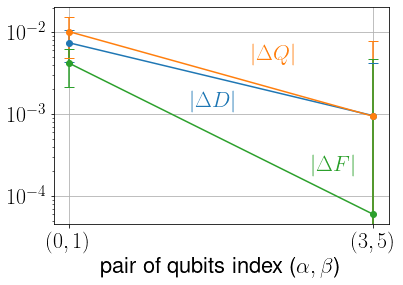

In [ ]:
for j in range(3):
    plt.errorbar( [0,1], error_mean[:,j], yerr=error_std[:,j], fmt='-o', capsize=5 )
plt.xticks( [0,1], labels=[ '$(0,1)$', '$(3,5)$' ]   )
plt.xlabel('pair of qubits index ($\\alpha,\\beta$)')
plt.grid()
plt.yscale('log')
plt.text( 0.8, 2e-4, '$|\\Delta F|$', color='tab:green' )
plt.text( 0.6, 4.5e-3, '$|\\Delta Q|$', color='tab:orange' )
plt.text( 0.4, 1.2e-3, '$|\\Delta D|$', color='tab:blue' )
plt.savefig('pa_vs_ind_double_quantities.png', bbox_inches='tight', transparent=True )
plt.savefig('pa_vs_ind_double_quantities.svg', bbox_inches='tight', transparent=True )

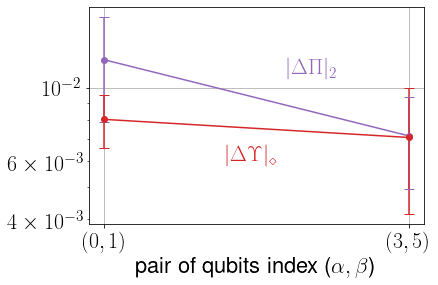

In [ ]:
plt.errorbar( [0,1], diamond_norms_mean[0], yerr=diamond_norms_std[0], fmt='-o', capsize=5, c = 'tab:purple' )
plt.errorbar( [0,1], diamond_norms_mean[1], yerr=diamond_norms_std[1], fmt='-o', capsize=5, c = 'tab:red' )
plt.xticks( [0,1], labels=[ '$(0,1)$', '$(3,5)$' ]   )
plt.text( 0.6, 1.1e-2, '$|\\Delta\\Pi|_2$', color='tab:purple' )
plt.text( 0.4, 6e-3, '$|\\Delta\\Upsilon|_\diamond$', color='tab:red' )
plt.xlabel('pair of qubits index ($\\alpha,\\beta$)')
plt.grid()
plt.yscale('log')
plt.savefig('pa_vs_ind_double_error.png', bbox_inches='tight', transparent=True )
plt.savefig('pa_vs_ind_double_error.svg', bbox_inches='tight', transparent=True )